## Contents
### YOLO v3 for image detection
0. <a href='#0.-Introduction'>Introduction</a>
1. <a href='#1.-Clone-and-Build-YOLOv3'>Clone and Build YOLOv3</a>
2. <a href='#2.-Data-Migration-for-YOLOv3'>Data Migration</a>
3. <a href='#3.-Prepare-Configuration-Files-for-Using-YOLOv3'>Prepare Configuration Files for training</a>
4. <a href='#4.-Training-YOLOv3'>Training model</a>
5. <a href='#5.-How-to-use-trainined-YOLOv3-for-test-images-(command-line)'>How to use trained model for test images (command line)</a>
6. <a href='#6.-Generate-Submission-Files-with-YOLOv3-Python-Wrapper'>Generate Submission Files Using YOLOv3 Python Wrapper</a>
7. <a href='#7.-Future-works-&-Etc'>Future works & Etc</a>

## 0. Introduction
* I'll introduce super easy and quick way to train [YOLOv3](https://pjreddie.com/darknet/yolo/) on RSNA and to generate submission file (to be honest, not super easy ...!).


* The purpose of this competition is 'object detection'. Generally, object detection algorithms with deep learning take a long time to train model and require a lot of gpu resources. Most individual participants use one or two gpu (... or zero). Therefore, there is a need for **algorithms that works quickly with less gpu resources.**


* I tried to use Mask R-CNN, UNet, Fast R-CNN and FCN algorithms, But eventually switched to YOLOv3.


* In comparison to YOLOv3, Other algorithms(Mask R-CNN, UNet, FCN, ...) which contain instance/sementic segmentation tasks are very slow, and require more gpu resources, redundant parameter tunning and post-processes. Therefore, if you try to use these algorithms, you may experience difficulties in terms of training time and gpu resources. (Please see [YOLOv3 paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf) for details)


* In addition, **YOLOv3 was able to obtain high score (LB: 0.141) without additional processes(data augmentation, parameter tunning, etc...)** compared to other algorithms. So I think YOLOv3 has sufficient potential for this competition.


* In this notebook, I'll introduce how to simply apply YOLOv3 on RSNA data. I hope this notebook would be helpful for everyone.

In [1]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# !pip install pydicom
# !pip install tqdm

In [3]:
random_stat = 123
np.random.seed(random_stat)

## 1. Clone and Build YOLOv3

In [4]:
# !git clone https://github.com/pjreddie/darknet.git
# I built it manually from the terminal

In [5]:
#!git clone https://github.com/pjreddie/darknet.git

# Build gpu version darknet
#!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
#!cd darknet && make -j 50 -s
#!cp darknet/darknet darknet_gpu

## 2. Data Migration for YOLOv3
It might take a while.

### 2.0. Make subdirectories

In [6]:
# DATA_DIR = "../input"
DATA_DIR = "./downloaded_data"
train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [7]:
!ls -shtl

total 166M
304K -rwxrwxrwx  1 qinghe qinghe 301K janv. 22 12:01 yolov3-rsna-starting-notebook.ipynb
 40K -rw-r--r--  1 qinghe qinghe  38K janv. 21 19:08 loss.png
8,0K -rw-r--r--  1 qinghe qinghe 6,4K janv. 21 18:41 submission.csv
4,0K drwxr-xr-x  2 qinghe qinghe 4,0K janv. 21 17:23 __pycache__
8,0K -rw-r--r--  1 qinghe qinghe 5,1K janv. 21 17:23 darknet.py
4,0K drwxrwxrwx  2 qinghe qinghe 4,0K janv. 21 16:56 cfg
4,0K drwxrwxrwx  2 qinghe qinghe 4,0K janv. 21 16:54 backup
224K -rwxrwxrwx  1 qinghe qinghe 222K janv. 21 16:54 test.jpg
8,9M -rwxrwxrwx  1 qinghe qinghe 8,9M janv. 21 16:54 train_log.txt
4,0K drwxr-xr-x 13 qinghe qinghe 4,0K janv. 21 11:47 darknet
4,0K drwxrwxrwx  2 qinghe qinghe 4,0K janv. 21 11:18 metadata
424K drwxrwxrwx  2 qinghe qinghe 424K janv. 21 11:18 labels
616K drwxrwxrwx  2 qinghe qinghe 616K janv. 21 11:18 images
4,0K drwxrwxrwx  4 qinghe qinghe 4,0K janv. 21 11:17 downloaded_data
   0 -rwxrwxrwx  1 qinghe qinghe    0 janv. 21 10:28 0
   0 -rwxrwxrwx  1 qinghe qi

### 2.1. Load stage_2_train_labels.csv

In [8]:
os.path.join(DATA_DIR, "stage_2_train_labels.csv")
# changes stage 1 to stage 2

'./downloaded_data/stage_2_train_labels.csv'

In [9]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


### 2.2. Generate images and labels for training YOLOv3
* YOLOv3 needs .txt file for each image, which contains ground truth object in the image that looks like:
```
<object-class_1> <x_1> <y_1> <width_1> <height_1>
<object-class_2> <x_2> <y_2> <width_2> <height_2>
```
* <object-class\>: Since RSNA task is binary classification basically, <object-class\> is 0.
* <x\>, <y\>: Those are float values of bbox center coordinate, divided by image width and height respectively.
* <w\>, <h\>: Those are width and height of bbox, divided by image width and height respectively.

* So it is different from the format of label data provided by kaggle. We should change it.

In [10]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        # Since kaggle kernel have samll volume (5GB ?), I didn't contain files with no bbox here.
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [11]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████| 30227/30227 [00:01<00:00, 17646.79it/s]


In [12]:
!du -sh images labels

1,5G	images
24M	labels


### 2.3. Plot a sample train image and label

In [30]:
test_dcm_fps[0]

'c040e4f2-467a-4078-beef-0ff693cfa952'

In [31]:
annots[annots.Target == 1].patientId.values[0]

'00436515-870c-4b36-a041-de91049b9ab4'

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



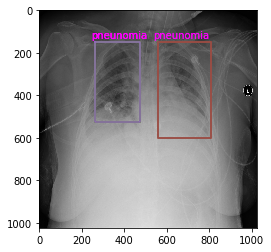

In [26]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])
        plt.annotate("pneunomia", (x-20, y-20), color="magenta")
        plt.savefig("test1.png", dpi=300)

### 2.4. Generate train/val file path list (.txt)
* We should give the list of image paths to YOLO. two seperate list textfiles for training images and validation images.

In [33]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [34]:
# Following lines do not contain data with no bbox
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 5410, The # of validation set: 602


### 2.5. Create test image and labels for YOLOv3

In [28]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [29]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)

### 2.6. Plot a sample test Image

In [ ]:
# # ex_patient_id = annots[annots.Target == 1].patientId.values[0]
# ex_patient_id = test_dcm_fps[0]
# ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
# ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

# plt.imshow(cv2.imread(ex_img_path))

# img_size = 1014
# with open(ex_label_path, "r") as f:
#     for line in f:
#         print(line)
#         class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
#         x = (rcx-rw/2)*img_size
#         y = (rcy-rh/2)*img_size
#         w = rw*img_size
#         h = rh*img_size
#         plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])
#         plt.annotate("pneunomia", (x-20, y-20), color="magenta")
#         plt.savefig("test1.png", dpi=300)

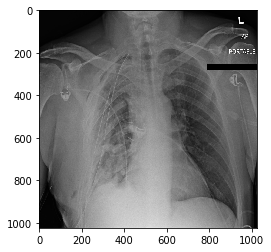

In [18]:
ex_patient_id = test_dcm_fps[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

## 3. Prepare Configuration Files for Using YOLOv3
We should prepare and modify config files, and bring pre-trained weights necessary for training. This proceeds with following four steps.
```
 cfg/rsna.data
 cfg/rsna.names
 darknet53.conv.74
 cfg/rsna_yolov3.cfg_train
```

### - cfg/rsna.data
This file point to RSNA data path
  * train: Path to training image list textfile
  * val: Path to validation image list textfile
  * names: RSNA class name list (see <a href='#3.1.-cfg/rsna.names'>3.1</a>)
  * backup: A directory where trained weights(checkpoints) will be stored as training progresses.

In [19]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [20]:
!cat cfg/rsna.data

classes= 1
train  = /home/qinghe/cri/projects/AI/yolo/metadata/tr_list.txt
valid  = /home/qinghe/cri/projects/AI/yolo/metadata/val_list.txt
names  = /home/qinghe/cri/projects/AI/yolo/cfg/rsna.names
backup = /home/qinghe/cri/projects/AI/yolo/backup
    

### - cfg/rsna.names

In [21]:
# Label list of bounding box.
!echo "pneumonia" > cfg/rsna.names

### - darknet53.conv.74  (Download Pre-trained Model)
For training, we would download the pre-trained model weights(darknet53.conv.74) using following wget command. I recommend you to use this pre-trained weight too. Author of darknet also uses this pre-trained weights in different fields of image recognition.

In [22]:
!wget -q https://pjreddie.com/media/files/darknet53.conv.74

### - cfg/rsna_yolov3.cfg_train
* Basically, you can use darknet/cfg/yolov3.cfg files. However it won't work for RSNA. you need to edit for RSNA.
* You can just download a cfg file I edited for RSNA with following wget command.


* I refer to the following articles for editing cfg files.
  * [YOLOv3 blog](https://pjreddie.com/darknet/yolo/)
  * [YOLOv3 paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf)
  * [how to train yolov2 blog](https://medium.com/@manivannan_data/how-to-train-yolov2-to-detect-custom-objects-9010df784f36)
  * [darknet github issues/236](https://github.com/pjreddie/darknet/issues/236)

In [23]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=18ptTK4Vbeokqpux8Onr0OmwUP9ipmcYO" -O cfg/rsna_yolov3.cfg_train

## 4. Training YOLOv3

### 4.0. Command for training with Pre-trained CNN Weights (darknet53.conv.74)
* I didn't run following command on kaggle kernel becuase of the long output.
* If you crash with  'CUDA Error: out of memory', Solve it by Editing 'batch' and 'subdivisions' in 'cfg/rsna_yolov3.cfg_train'
* If 'batch' and 'subdivisions' are 64 and 64 respectively, for every iteration only one image will be loaded on GPU memory. So it will use less GPU memory.

In [24]:
#!./darknet_gpu detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt

In [25]:
!./darknet detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt

/bin/sh: 1: ./darknet: Permission denied


### 4.1. Command for training with Multi-gpu after 1000 iteration

If you are trying to train with multi-gpu, there are three things to watch out.
* (The # of gpus)x('learning rate' in 'cfg/rsna_yolov3.cfg_train') is the real learning rate for training
* I don't recommend you to use multi-gpu for first 1000 iterations. with multi-gpu, training would not be stable. Use single gpu before 1000 and after 1000, continue with more gpus.
* By the way, If the # of gpus is over 5, training is not stable.

```
Above things will depend on your environment. The best way to find the most appropriate method is to just give it a try :)
```

In [26]:
# !./darknet_gpu detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train backup/rsna_yolov3_1000.weights -gpus 0,1,2,3 | tee train_log.txt

### 4.2. My Plot of Training Loss
It's a loss graph up to about 2000 iteration. Since it tooks too long on kaggle kernel, I brought it. When learning, don't be surprised of big loss values at the beginning. Stay calm and It'll go down. Please See the following loss graph.

In [27]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1OhnlV3s7r6xsEme6DKkNYjcYjsl-C_Av" -O train_log.txt

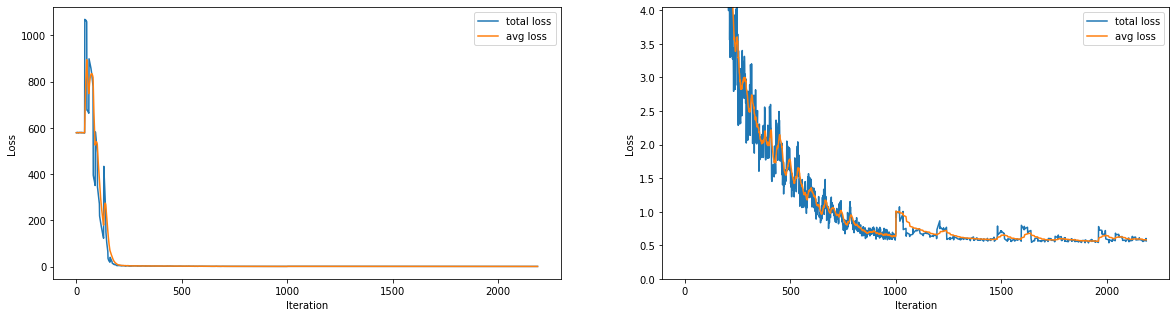

In [47]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 4.05])
plt.savefig("loss.png")

## 5. How to use trainined YOLOv3 for test images (command line)

### 5.0. Copy sample test image

In [29]:
ex_patient_id = annots[annots.Target == 1].patientId.values[2]
shutil.copy(ex_img_path, "test.jpg")
print(ex_patient_id)

00704310-78a8-4b38-8475-49f4573b2dbb


### 5.1. Load trained model (at 15300 iteration)
Since i uploaded the weights file (large big file) on my google drive, the command is very very long ...
* It's a weight file at 15300 iteration, which I made submission file with. If you use this weight, you'll get a score of 0.141LB.
  * Up to 15300 iteration, It takes about 8 hours.
    * In .cfg file, I set 'batch' and 'subdivisions' as 64 and 8 respectively.
    * Up to 1000 iteration from 0, it takes about 1h with **one** Tesla P100 GPU.      **(1000 iter/h)**
    * Up to 15300 iteration from 1000, it takes about 7h with **four** Tesla P100 GPU. **(2043 iter/h)**

In [30]:
!wget --load-cookies /tmp/cookies.txt -q "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd" -O backup/rsna_yolov3_15300.weights && rm -rf /tmp/cookies.txt

In [31]:
!ls -alsth backup

total 235M
235M -rw-r--r--  1 qinghe qinghe 235M janv. 21 16:56 rsna_yolov3_15300.weights
4,0K drwxr-xr-x 10 qinghe qinghe 4,0K janv. 21 16:55 ..
4,0K drwxrwxrwx  2 qinghe qinghe 4,0K janv. 21 16:54 .


### 5.2. cfg file for test (not for training)

In [32]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=10Yk6ZMAKGz5LeBbikciALy82aK3lX-57" -O cfg/rsna_yolov3.cfg_test

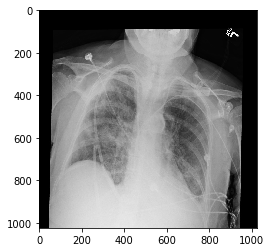

In [53]:
plt.imshow(cv2.imread(os.path.join(img_dir, "{}.jpg".format(val_series.tolist()[2]))))

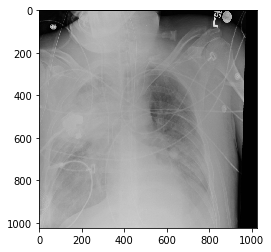

In [54]:
plt.imshow(cv2.imread(aa))

In [67]:
aa = os.path.join(img_dir, "{}.jpg".format(val_series.tolist()[1]))

In [68]:
print(aa)

/home/qinghe/cri/projects/AI/yolo/images/d373b335-d9d9-4594-b97e-03ec9aa8daa2.jpg


In [70]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_15300.weights /home/qinghe/cri/projects/AI/yolo/images/d373b335-d9d9-4594-b97e-03ec9aa8daa2.jpg -thresh 0.5

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

Loading weights from ../backup/rsna_yolov3_15300.weights...Done!
/home/qinghe/cri/projects/AI/yolo/images/d373b335-d9d9-4594-b97e-03ec9aa8daa2.jpg: Predicted in 21.916307 seconds.
pneumonia: 94%
pneumonia: 76%
^C


In [73]:
!cd darknet && ./darknet detector recall ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_15300.weights -out ""

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

Loading weights from ../backup/rsna_yolov3_15300.weights...Done!
Learning Rate: 0.001, Momentum: 0.9, Decay: 0.0005
Couldn't open file: data/coco_val_5k.list


In [33]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_15300.weights ../test.jpg -thresh 0.005

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

Loading weights from ../backup/rsna_yolov3_15300.weights...Done!
../test.jpg: Predicted in 22.670948 seconds.
pneumonia: 66%
^C


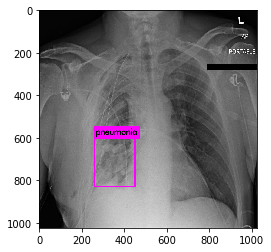

In [34]:
# ![](predictions.jpg)
plt.imshow(cv2.imread("./darknet/predictions.jpg"))

## 6. Generate Submission Files with YOLOv3 Python Wrapper

### 6.0. Download darknet python wrapper (darknet.py)
* Basically, you can use darknet/python/darknet.py files. However it'll show error.
* So, I edited the darknet.py. There are two main modifications.
  * Change print statement to print function for python3
  * Edit dynamic library('libdarknet.so') file path
* I leaved '# ===' marks where i edited in darknet.py. For example,
```
# ==============================================================================
#lib = CDLL("/home/pjreddie/documents/darknet/libdarknet.so", RTLD_GLOBAL)
darknet_lib_path = os.path.join(os.getcwd(), "darknet", "libdarknet.so")
lib = CDLL(darknet_lib_path, RTLD_GLOBAL)
# ==============================================================================
```

In [35]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1-KTV7K9G1bl3SmnLnzmpkDyNt6tDmH7j" -O darknet.py

### 6.1. Load darknet python wrapper module

In [36]:
from darknet import *

### 6.2. Generate submission files
* When making submission files, be aware of label format which is different in yolo.

In [37]:
threshold = 0.2

In [38]:
submit_file_path = "submission.csv"
cfg_path = os.path.join(cfg_dir, "rsna_yolov3.cfg_test")
weight_path = os.path.join(backup_dir, "rsna_yolov3_15300.weights")

test_img_list_path = os.path.join(metadata_dir, "te_list.txt")

In [43]:
test_img_list_path

'/home/qinghe/cri/projects/AI/yolo/metadata/te_list.txt'

In [39]:
gpu_index = 0
net = load_net(cfg_path.encode(),
               weight_path.encode(), 
               gpu_index)
meta = load_meta(data_extention_file_path.encode())

In [ ]:
#"/home/qinghe/cri/projects/AI/yolo/images/2fe3ba48-ce4d-42a4-8eda-99e3eb40d5fe.jpg"

In [44]:
submit_dict = {"patientId": [], "PredictionString": []}

with open(test_img_list_path, "r") as test_img_list_f:
    # tqdm run up to 1000(The # of test set)
    for line in tqdm(test_img_list_f):
        patient_id = line.strip().split('/')[-1].strip().split('.')[0]
        patient_id
        infer_result = detect(net, meta, line.strip().encode(), thresh=threshold)
        infer_result
        submit_line = ""
        for e in infer_result:
            confi = e[1]
            w = e[2][2]
            h = e[2][3]
            x = e[2][0]-w/2
            y = e[2][1]-h/2
            submit_line += "{} {} {} {} {} ".format(confi, x, y, w, h)

        submit_dict["patientId"].append(patient_id)
        submit_dict["PredictionString"].append(submit_line)

pd.DataFrame(submit_dict).to_csv(submit_file_path, index=False)


0it [00:00, ?it/s]
1it [00:23, 23.93s/it]
2it [00:47, 23.82s/it]
3it [01:10, 23.69s/it]
4it [01:33, 23.33s/it]
5it [01:57, 23.57s/it]
6it [02:20, 23.44s/it]
7it [02:43, 23.29s/it]
8it [03:05, 23.00s/it]
9it [03:28, 22.77s/it]
10it [03:50, 22.57s/it]
11it [04:12, 22.42s/it]
12it [04:34, 22.32s/it]
13it [04:56, 22.36s/it]
14it [05:18, 22.20s/it]
15it [05:40, 22.10s/it]
16it [06:02, 22.03s/it]
17it [06:24, 22.15s/it]
18it [06:50, 23.26s/it]
19it [07:15, 23.63s/it]
20it [07:38, 23.67s/it]
21it [08:04, 24.25s/it]
22it [08:30, 24.81s/it]
23it [08:56, 25.23s/it]
24it [09:23, 25.64s/it]
25it [09:50, 26.05s/it]
26it [10:15, 25.59s/it]
27it [10:39, 25.39s/it]
28it [11:05, 25.52s/it]
29it [11:32, 25.75s/it]
30it [11:57, 25.54s/it]
31it [12:19, 24.70s/it]
32it [12:41, 23.81s/it]
33it [13:03, 23.28s/it]
34it [13:26, 23.17s/it]
35it [13:49, 23.19s/it]
36it [14:12, 22.93s/it]
37it [14:34, 22.84s/it]
38it [14:57, 22.76s/it]
39it [15:18, 22.42s/it]
40it [15:41, 22.51s/it]
41it [16:03, 22.24s/it]
42it 

KeyboardInterrupt: 

In [45]:
pd.DataFrame(submit_dict).to_csv(submit_file_path, index=False)

In [ ]:
# !ls -lsht
!rm -rf darknet images labels metadata backup cfg
!rm -rf train_log.txt darknet53.conv.74 darknet.py darknet_gpu
!rm -rf test.jpg
!rm -rf __pycache__ .ipynb_checkpoints

In [ ]:
!ls -alsht

## 7. Future works & Etc

### Future works (Things to try)
* Image augmentation
* More training
* Utilizing the not labeled images because we got rid of not labeled images above

### ETC
* For a private matter, i can not proceed RSNA task after 09/27. If you have any ideas, questions and problems with this kernel after 09/27, Please leave those things anyway~! Collaborator '@John Byun' will reply to your comments.